# Lasso Regression From Scratch
***
## Table of Contents
1. [Introduction](#1-introduction)
    - [Advantages](#advantages)
    - [Limitations](#limitations)
1. [Loading Data](#2-loading-data)
1. [Standardisation](#3-standardisation)
1. [Linear Regression Model](#4-linear-regression-model)
1. [Lasso Loss Function](#5-lasso-loss-function)
1. [Gradient Descent](#6-gradient-descent)
1. [Model Evaluation](#6-model-evaluation)
    - [Mean Squared Error (MSE)](#mean-squared-error-mse)
    - [Root Mean Squared Error (RMSE)](#root-mean-squared-error-rmse)
    - [Mean Absolute Error (MAE)](#mean-absolute-error-mae)
    - [R-Squared ($R^2$)](#r-squared)
1. [Encapsulation](#8-encapsulation)
1. [k-Fold Cross Validation](#9-k-fold-cross-validation)
    - [Advantages](#advantages)
    - [Steps](#steps)
1. [Comparison with Scikit-Learn](#10-comparison-with-scikit-learn)
1. [References](#11-references)
***


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple
from numpy.typing import NDArray

## 1. Introduction

This notebook is an extension of [Linear Regression from Scratch](https://github.com/tsu76i/DS-playground/blob/main/2.%20Building%20ML%20Models%20From%20Scratch/2.1%20Supervised%20Learning/2.1.1%20Regressions/linear_regression.ipynb).

Lasso Regression (Least Absolute Shrinkage and Selection Operator) is a linear regression technique that incorporates **L1 regularisation**. It modifies the standard least square loss function by adding a penalty proportional to the sum of the absolute values of the coefficients.

### Advantages
- Lasso regression performs both regularisation and feature selection by shrinking some coefficients exactly to zero. This results in a sparse model that includes only the most relevant predictors, simplifying interpretation and reducing model complexity.
- Lasso can handle multicollinearity by selecting one variable from a group of highly correlated predictors and shrinking the rest to zero, thus reducing redundancy in the model.
- By penalising large coefficients, Lasso helps prevent overfitting especially in high-dimensional datasets.


### Limitations
- The regularisation strength $\lambda$ must be chosen carefully, often via cross-validation. Poor choice of this parameter can lead to underfitting or insufficient regularisation.
- The L1 penalty introduces bias by shrinking coefficients towards zero. As a result, the estimated coefficients may not reflect the true magnitude of the relationships, especially when the regularisation parameter is large.
- Lasso regression is sensitive to the scale of the predictors. It is essential to standardise features before applying lasso regression to ensure fair penalisation.

## 2. Loading Data

In [2]:
linear_data = pd.read_csv("../../_datasets/linear_data.txt", header=None)
X = np.array(linear_data.iloc[:, 0])
y = np.array(linear_data.iloc[:, 1])

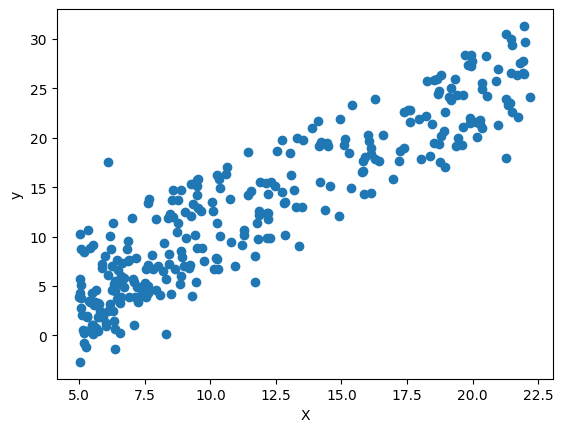

In [3]:
plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

## 3. Standardisation
Lasso regression penalises the absolute value of the coefficients (L1 norm). If the input features are on different scales, the regularisation penalty is applied unevenly, causing features with larger scales to dominate the regularisation term and reducing overall model performance. To address this issue, it is essential to standardise all features before applying lasso regression, as this ensures that all features contribute equally to the penalty. This process not only makes the regularisation fair but also improves numerical stability. The mathematical definition of standardisation for each feature $x_j$ is as follows:

\begin{align*}
    x_j^{\text{standardised}} = \dfrac{x_j - \mu_j}{\sigma_j}
\end{align*}

where:
- $\mu_j$: The mean of feature $j$.
- $\sigma_j$: The standard deviation of feature $j$.

In [4]:
def standardise(X: NDArray[np.float64]) -> NDArray[np.float64]:
    X_mean = np.mean(X)
    X_std = np.std(X)
    return (X - X_mean) / X_std

In [5]:
print(f'Before standardisation: {X[:5]}')
X = standardise(X)
print(f'After standardisation: {X[:5]}')

Before standardisation: [6.1101 5.5277 8.5186 7.0032 5.8598]
After standardisation: [-1.0449549  -1.15259751 -0.59980172 -0.87988689 -1.09121682]


## 4. Linear Regression Model

A linear regression model provides numerical predictions as a straight line on a dataset, assuming a linear relationship between two numerical variables. The formula for a simple linear regression is:

\begin{align*}
h = wx + b
\end{align*}

Where:

- $x$ is the independent variable.
- $w$ is the slope (weight, coefficient of $x$).
- $b$ is the intercept (bias, constant term).

In [6]:
# Linear function h
def h(w: float, b: float, x: float) -> float:
    return w * x + b

## 5. Lasso Loss Function
Lasso regression introduces a L1 penalty to the standard mean squared error (MSE) loss function. The regularised loss function becomes:

\begin{align*}
    \mathcal{L}_{\text{Lasso}}(w, b) = \dfrac{1}{n} \sum^{n}_{i=1}(y_i - (wx_i + b))^2 + \lambda |w|
\end{align*}

where:
- $y_i$: True target value  for the $i$-th sample $x_i$.
- $wx_i + b = \hat y_i$: Predicted target value for the $i$-th sample $x_i$.
- $w$: Vector of regression coefficients.
- $\lambda \geq 0$: Regularisation parameter.

In [7]:
# Compute Lasso Loss function (MSE + L1 penalty)
def calculate_loss_lasso(w: float, b: float, X: NDArray[np.float64], y: NDArray[np.float64], lambda_: float) -> float:
    total_err: float = 0.0
    for i in range(len(X)):
        y_hat = h(w, b, X[i])
        total_err += (y[i] - y_hat) ** 2
    mse = total_err / len(X)
    l1_penalty = lambda_ * np.abs(w)
    return mse + l1_penalty

## 6. Gradient Descent
The gradients of the loss function with respect to $w$ and $b$ becomes:

\begin{align*}
    \frac{\partial \mathcal{L}_{\text{Lasso}}}{\partial w} = - \frac{2}{n}\sum^{n}_{i=1}(y_i - (wx_i+b))x_i +  \lambda \cdot \operatorname{sign}(w)
    
\end{align*}

where $\operatorname{sign}(w) = 
\begin{cases}
    1  & \text{if } w > 0 \\
    -1 & \text{if } w < 0 \\
    0  & \text{if } w = 0
\end{cases}$


\begin{align*}
    \frac{\partial \mathcal{L}_{\text{Lasso}}}{\partial b} = - \frac{2}{n}\sum^{n}_{i=1}(y_i - (wx_i+b))
\end{align*}

Note that the intercept $b$ is typically **not regularised**.

In [8]:
def derivative_lasso(X: NDArray[np.float64], y: NDArray[np.float64], y_pred: NDArray[np.float64], n: int, w: float, lambda_: float) -> Tuple[float, float]:
    dL_dw: float = -2 * np.sum((y - y_pred) * X) / n + lambda_ * np.sign(w)
    dL_db: float = -2 * np.sum(y - y_pred) / n
    return dL_dw, dL_db


# Batch Gradient Descent for Lasso Regression
def gradient_descent_lasso(w: float, b: float, X: NDArray[np.float64], y: NDArray[np.float64],
                           alpha: float, epochs: int, n: int, lambda_: float) -> Tuple[float, float, NDArray[np.float64]]:
    loss_list: list[float] = []
    for _ in range(epochs):
        y_pred: NDArray[np.float64] = h(w, b, X)
        loss_list.append(calculate_loss_lasso(w, b, X, y, lambda_))
        dL_dw, dL_db = derivative_lasso(X, y, y_pred, n, w, lambda_)
        w -= alpha * dL_dw
        b -= alpha * dL_db
    return w, b, np.array(loss_list)

In [9]:
# Example
alpha = 0.001
n = len(y)
epochs = 10000
lambda_ = 1.0  # Regularisation strength

coeff_GD, intercept_GD, loss_array = gradient_descent_lasso(
    0, 0, X, y, alpha, epochs, n, lambda_
)
print(f'Coefficient (GD): {coeff_GD:.5f}, Intercept (GD): {intercept_GD:.5f}')

Coefficient (GD): 6.94728, Intercept (GD): 12.80548


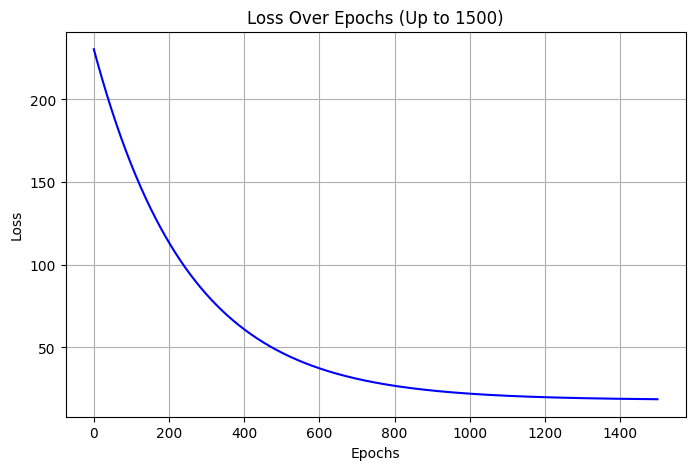

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(loss_array[:1500], color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs (Up to 1500)')
plt.grid(True)
plt.show()

## 7. Model Evaluation


### Mean Squared Error (MSE)
Mean Squared Error measures the average squared difference between predicted ($\hat y$) and actual ($y$) values. Large errors are penalised heavily. Smaller MSE indicates better predictions.

\begin{align*}
MSE = \dfrac{1}{n} \sum_{i=1}^{n}(\hat y_{i} = y_{i})^2
\end{align*}

In [11]:
def calculate_MSE(y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
    return np.mean((y_true - y_pred) ** 2)

### Root Mean Squared Error (RMSE)
Square root of MSE. It provides error in the same unit as the target variable ($y$) and easier to interpret.

\begin{align*}
RMSE = \sqrt{(MSE)}
\end{align*}

In [12]:
def calculate_RMSE(y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

### Mean Absolute Error (MAE)
Mean Absolute Error measures the average absolute difference between predicted ($\hat y$) and actual ($y$) values. It is less sensitive to outliers than MSE. Smaller MAE indicates better predictions.

\begin{align*}
MAE = \dfrac{1}{n} \sum_{i=1}^{n}|\hat y_{i} = y_{i}|
\end{align*}

In [13]:
def calculate_MAE(y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
    return np.mean(np.abs(y_true - y_pred))

<a id="r-squared"></a>
### R-Squared($R^2$)

R-squared indicated the proportion of variance in the dependent variable that is predictable from the independent variables. Value ranges from 0 to 1. Closer to 1 indicates a better fit.



Residual Sum of Squares ($SS_{residual}$): 
\begin{align*}
SS_{residual} = \sum_{i=1}^{n} (y_{i} - \hat y_{i})^{2}
\end{align*}

Total Sum of Squares ($SS_{total}$): 
\begin{align*}
SS_{total} = \sum_{i=1}^{n} (y_{i} - \bar y_{i})^{2}
\end{align*}

$R^2$ is computed as:

\begin{align*}

R^2 = 1 - \dfrac{SS_{residual}}{SS_{total}} = 1 - \dfrac{\sum_{i=1}^{n} (y_{i} - \hat y_{i})^{2}}{\sum_{i=1}^{n} (y_{i} - \bar y_{i})^{2}}

\end{align*}

where:

$y$: Actual target values.

$\bar y$: Mean of the actual target values.

$\hat y$: Precicted target values.

In [14]:
def calculate_r2(y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

In [15]:
def evaluate(y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> Tuple[float, float, float, float]:
    """
    Calculate and return evaluation metrics for a regression model, including MSE, RMSE, MAE, and R-squared.

    Args:
        y_true : True target values.
        y_pred: Predicted target values.

    Returns:
        - mse: Mean Squared Error (MSE), indicating the average of the squared differences between predicted and true values.
        - rmse: Root Mean Squared Error (RMSE), indicating the standard deviation of the residuals.
        - mae: Mean Absolute Error (MAE), representing the average absolute difference between predicted and true values.
        - r2: R-squared (coefficient of determination), showing the proportion of variance in the dependent variable that is predictable from the independent variable(s).
    """
    mse = calculate_MSE(y_true, y_pred)
    rmse = calculate_RMSE(y_true, y_pred)
    mae = calculate_MAE(y_true, y_pred)
    r2 = calculate_r2(y_true, y_pred)
    return mse, rmse, mae, r2

## 8. Encapsulation

In [16]:
class CustomLassoRegression:
    """
    A simple implementation of Lasso Regression using gradient descent.
    """

    def __init__(self, w: float = 0.0, b: float = 0.0,
                 alpha: float = 0.001, epochs: int = 20000, lambda_: float = 1.0) -> None:
        """
        Initialise the CustomLassoRegression instance with given hyperparameters.

        Args:
            w: Initial weight (default is 0.0).
            b: Initial bias (default is 0.0).
            alpha: Learning rate for gradient descent (default is 0.001).
            epochs: Number of iterations for gradient descent (default is 20000).
            lambda_: L1 Regularisation parameter (default is 1.0).
        """
        self.w = w
        self.b = b
        self.alpha = alpha
        self.epochs = epochs
        self.lambda_ = lambda_
        self.loss_history = []

    def predict(self, X: float) -> float:
        """
        Predict the output for a given input using the regression line.

        Args:
            X: Input feature value.

        Returns:
            Predicted value.
        """
        return self.w * X + self.b

    def calculate_loss_lasso(self, y: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
        """
        Calculate Lasso Loss function (MSE + L1 penalty).

        Args:
            y: True output values.
            y_pred: Predicted output values.

        Returns:
            MSE + L1 penalty.
        """
        mse = np.mean((y - y_pred) ** 2)
        l1_penalty = self.lambda_ * np.abs(self.w)
        return mse + l1_penalty

    def gradient_descent(self, X: NDArray[np.float64], y: NDArray[np.float64]) -> None:
        """
        Perform gradient descent to optimise the parameters w and b.

        Args:
            X: Input feature values.
            y: True output values.
        """
        n: int = len(y)
        for _ in range(self.epochs):
            y_pred = np.array([self.predict(x_i) for x_i in X])

            loss = self.calculate_loss_lasso(y, y_pred)
            self.loss_history.append(loss)

            dL_dw = -(2 / n) * np.sum(X * (y - y_pred)) + \
                self.lambda_ * np.sign(self.w)
            dL_db = -(2 / n) * np.sum(y - y_pred)

            self.w -= self.alpha * dL_dw
            self.b -= self.alpha * dL_db

    def train(self, X: NDArray[np.float64], y: NDArray[np.float64]) -> None:
        """
        Train the model using gradient descent.

        Args:
            X: Input feature values.
            y: True output values.
        """
        self.gradient_descent(X, y)
        print(
            f"Training completed. Coefficient: {self.w:.5f}, Intercept: {self.b:.5f}")

## 9. k-Fold Cross Validation
k-fold cross validation systematically splits the dataset into $k$ subsets (called *folds*) and evaluates the generalisation performance of machine learning models. It ensures that every data point is used for both training and validation exactly once. It provides a principled way to evaluate different regularisation parameter ($\lambda$) values and select the one that minimises prediction error on data not used for training.

### Advantages
- **Reduces overfitting**: By validating on multiple subsets, it provides a more reliable estimate of model performance on unseen data.
- **Efficient Data Utilisation**: Every observation is used for both training and validation, maximising the use of limited data.
- **Stable Performance Estimate**: Averaging results over k folds reduces the variance and bias of the performance metric.

### Steps
1. Choose the number of folds (k)
    - Typically $k = 5$ or $10$.
2. Shuffle and split the data
    - Randomly shuffle the dataset to ensure each fold is representative.
    - Divide the data into k folds of (approximately) equal size.
3. Iterative training and validation
    - For each fold $i$ (where $i = 1,...,k$)
        - Use the $i$-th fold as the validation (test) set.
        - Use the remaining $k-1$ folds as the training set.
        - Train the model on the training set.
        - Evaluate the model on the validation set and record the performance.
4. Arregate the results
    - Calculate the mean of the recorded performance metrics as an overall estimate.

In [17]:
def cross_validate_lasso(X: np.ndarray, y: np.ndarray, lambdas: list, k: int = 5,
                         alpha: float = 0.001, epochs: int = 20000, random_state: int = 42) -> dict:
    """
    Perform k-fold cross-validation for CustomLassoRegression over a grid of lambda values.

    Args:
        X: Feature array (1D or 2D).
        y: Target array.
        lambdas: List of lambda values to evaluate.
        k: Number of folds (default 5).
        alpha: Learning rate for gradient descent.
        epochs: Number of training epochs.
        random_state: Seed for reproducibility.

    Returns:
        Dictionary mapping lambda to average validation MSE.
    """
    np.random.seed(random_state)
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    fold_sizes = np.full(k, len(y) // k, dtype=int)  # Split equally
    fold_sizes[:len(y) % k] += 1  # Distibute remainder
    current = 0
    folds = []
    for fold_size in fold_sizes:  # Split randomised indices into k folds
        start, stop = current, current + fold_size
        # folds contain k folds of randomised indices
        folds.append(indices[start:stop])
        current = stop

    lambda_mse = {}
    for lambda_ in lambdas:
        mse_scores = []
        for i in range(k):
            val_idx = folds[i]  # i-th fold = validation
            # All other folds = training
            train_idx = np.hstack([folds[j] for j in range(k) if j != i])
            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]

            model = CustomLassoRegression(
                w=0, b=0, alpha=alpha, epochs=epochs, lambda_=lambda_)
            model.train(X_train, y_train)
            y_pred = model.predict(X_val)
            mse = np.mean((y_val - y_pred) ** 2)
            mse_scores.append(mse)
        lambda_mse[lambda_] = float(np.mean(mse_scores).round(4))
    return lambda_mse

In [18]:
# Example grid of lambda values
lambdas = [0.001, 0.01, 0.1, 1, 10, 100]

# Run cross-validation
cv_results = cross_validate_lasso(
    X, y, lambdas, k=5, alpha=0.001, epochs=10000, random_state=42)

# Find the best lambda
best_lambda = min(cv_results, key=cv_results.get)
print('----------')
print(f'Best lambda: {best_lambda}')
print(f'Cross-validated MSEs: {cv_results}')

Training completed. Coefficient: 7.55311, Intercept: 12.81405
Training completed. Coefficient: 7.28910, Intercept: 12.91037
Training completed. Coefficient: 7.40478, Intercept: 12.77532
Training completed. Coefficient: 7.58482, Intercept: 12.65091
Training completed. Coefficient: 7.39543, Intercept: 12.88273
Training completed. Coefficient: 7.54864, Intercept: 12.81408
Training completed. Coefficient: 7.28456, Intercept: 12.91060
Training completed. Coefficient: 7.40039, Intercept: 12.77521
Training completed. Coefficient: 7.58032, Intercept: 12.65088
Training completed. Coefficient: 7.39081, Intercept: 12.88261
Training completed. Coefficient: 7.50390, Intercept: 12.81440
Training completed. Coefficient: 7.23922, Intercept: 12.91288
Training completed. Coefficient: 7.35643, Intercept: 12.77413
Training completed. Coefficient: 7.53529, Intercept: 12.65063
Training completed. Coefficient: 7.34464, Intercept: 12.88137
Training completed. Coefficient: 7.05654, Intercept: 12.81761
Training

By applying k-fold cross-validation, we found that the optimal value for the L1 regularisation parameter ($\lambda$) is $0.001$ among the candidates $[0.001, 0.01, 0.1, 1, 10, 100]$. As $\lambda$ increases, the penalty term becomes more dominant, progressively shrinking the coefficients and leading to underfitting. This result indicates that the best predictive performance is achieved with only a slight penalty on the magnitude of the coefficients. In other words, the model does not require substantial regularisation to generalise well to unseen data.

In [19]:
model = CustomLassoRegression(
    w=0, b=0, alpha=0.001, epochs=epochs, lambda_=best_lambda)
model.train(X, y)

y_pred = model.predict(X)
mse_custom, rmse_custom, mae_custom, r2_custom = evaluate(y, y_pred)
print(f'MSE (Custom): {mse_custom:.4f}')
print(f'RMSE (Custom): {rmse_custom:.4f}')
print(f'MAE (Custom): {mae_custom:.4f}')
print(f'R-Squared (Custom): {r2_custom:.4f}')
print('----------')

Training completed. Coefficient: 7.44678, Intercept: 12.80548
MSE (Custom): 10.9521
RMSE (Custom): 3.3094
MAE (Custom): 2.7396
R-Squared (Custom): 0.8351
----------


## 10. Comparison with Scikit-Learn

In [20]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
X_sk = X.reshape(-1, 1)  # X expected to be 2D array
lasso_cv = LassoCV(alphas=lambdas, cv=5, random_state=42)
lasso_cv.fit(X_sk, y)

print("Optimal lambda (alpha):", lasso_cv.alpha_)

y_pred_sk = lasso_cv.predict(X_sk)
mse_sk = mean_squared_error(y, y_pred_sk)
rmse_sk = np.sqrt(mse_sk)
mae_sk = mean_absolute_error(y, y_pred_sk)
r2_sk = r2_score(y, y_pred_sk)

print(f'MSE (sklearn): {mse_sk:.4f}')
print(f'MSE (Custom): {mse_custom:.4f}')
print('----------')
print(f'RMSE (sklearn): {rmse_sk:.4f}')
print(f'RMSE (Custom): {rmse_custom:.4f}')
print('----------')
print(f'MAE (sklearn): {mae_sk:.4f}')
print(f'MAE (Custom): {mae_custom:.4f}')
print('----------')
print(f'R-Squared (sklearn): {r2_sk:.4f}')
print(f'R-Squared (Custom): {r2_custom:.4f}')

Optimal lambda (alpha): 0.001
MSE (sklearn): 10.9521
MSE (Custom): 10.9521
----------
RMSE (sklearn): 3.3094
RMSE (Custom): 3.3094
----------
MAE (sklearn): 2.7397
MAE (Custom): 2.7396
----------
R-Squared (sklearn): 0.8351
R-Squared (Custom): 0.8351


## 11. References

1. DataMListic. (2025). *L1 vs L2 Regularization* [YouTube Video]. <br>
https://youtu.be/aBgMRXSqd04

1. GeeksforGeeks. (2025). *What is Lasso Regression?* <br>
https://www.geeksforgeeks.org/machine-learning/what-is-lasso-regression/

1. GeeksforGeeks. (2025). *K- Fold Cross Validation in Machine Learning*. <br>
https://www.geeksforgeeks.org/machine-learning/k-fold-cross-validation-in-machine-learning/

1. Jason Brownlee. (2023). *A Gentle Introduction to k-fold Cross-Validation*. <br>
https://machinelearningmastery.com/k-fold-cross-validation/

1. Lance Johnson. (2025). *Benefits of lasso regression: Transforming predictive modeling in data science*. <br>
https://www.byteplus.com/en/topic/401095?title=benefits-of-lasso-regression-transforming-predictive-modeling-in-data-science

1. Nisha Arya. (2022). *Why Use k-fold Cross Validation?* <br>
https://www.kdnuggets.com/2022/07/kfold-cross-validation.html

1. IBM. (2024). *What is lasso regression?* <br>
https://www.ibm.com/think/topics/lasso-regression

1. StatQuest with Josh Starmer. (2018). *Regularization Part 2: Lasso (L1) Regression* [YouTube Video]. <br>
https://youtu.be/NGf0voTMlcs

1. scikit-learn. (n.d.). *LassoCV — scikit-learn API Reference.* <br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html